# MASTER - Notebook 3
### Matteo Grazioso 884055

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime
import re
import folium
from folium.plugins import MarkerCluster
from geopy.geocoders import Nominatim
from pandas import Timestamp
import json
import warnings
warnings.filterwarnings('ignore')

import myfunctions as mf # Custom functions

In [3]:
# Disply all columns and all rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
# Find all txt files in the data folder
txt_files = mf.find_txt_files("data/processed")

# Choose a dataset from the list of txt files
selected_dataset = mf.choose_dataset(txt_files)

if selected_dataset:
    print(f"You selected the dataset {selected_dataset}")
else:
    print("No dataset selected.")

path  = selected_dataset

The following TXT files were found:
1. data/processed/dataset_cleaned_esportazioneCompleta.txt
2. data/processed/dataset_cleaned_esportazionePasqua23.txt
3. data/processed/dataset_cleaned_tempexport.txt
4. data/processed/dataset_cleaned_validazioni.txt
5. data/processed/old smaller/dataset_cleaned_esportazioneCompleta.txt
6. data/processed/old smaller/dataset_cleaned_validazioni.txt
You selected the dataset data/processed/dataset_cleaned_esportazionePasqua23.txt


In [5]:
# The file contains the data of the validation of tickets in the city of public transport of Venice.
# The file has been created by the Notebook 1.ipynb

df = pd.read_csv(path, header=0, sep='\t')

# Save the name of the file in a variable for future use extracting the name of the file from the path
file_name = path.split('_')[-1].split('.')[0]
subfolder = file_name

# Display the first 5 rows of the dataframe
df.head()

# Convert the column 'DATA' to datetime format
df['DATA'] = pd.to_datetime(df['DATA'], format='%Y-%m-%d')

In [6]:
def open_dict_trajectories(is_focus_on_ticket_code: bool = False, ticket_code: str = "", is_focus_on_tourists: bool = False, is_focus_on_workers: bool = False) -> dict:
    """
        This function opens the dictionary of trajectories eventually filtered by ticket code, tourists or workers.
        :param is_focus_on_ticket_code: if True, the dictionary will be filtered by ticket code
        :param ticket_code: the ticket code to filter the dictionary
        :param is_focus_on_tourists: if True, the dictionary will be filtered by tourists
        :param is_focus_on_workers: if True, the dictionary will be filtered by workers
        :return: the dictionary of trajectories eventually filtered
    """
    if is_focus_on_ticket_code:
        # Open the dictionary of trajectories filtered by ticket code
        with open('data/dictionaries/trajectories/' + subfolder + '/dict_trajectories_' + file_name + '_tc:' + ticket_code + '.json') as f:
            data = json.load(f)
        return data
    elif is_focus_on_tourists:
        # Open the dictionary of trajectories filtered by tourists
        with open('data/dictionaries/trajectories/' + subfolder + '/dict_trajectories_' + file_name + '_tourists.json') as f:
            data = json.load(f)
        return data
    elif is_focus_on_workers:
        # Open the dictionary of trajectories filtered by workers
        with open('data/dictionaries/trajectories/' + subfolder + '/dict_trajectories_' + file_name + '_workers.json') as f:
            data = json.load(f)
        return data
    else:
        # Open the dictionary of trajectories without filters
        with open('data/dictionaries/trajectories/' + subfolder + '/dict_trajectories_' + file_name + '.json') as f:
            data = json.load(f)
        return data

In [7]:
def extract_values_key(key: str) -> tuple:
    """
        This function extracts the values of the key.
        :param key: the key in the format (serial, day) where day can be None
        :return: the key in a tuple format (serial, day)
    """
    pattern = r"\((-?\d+),\s?(None|Timestamp\('.*'\))\)"
    match = re.match(pattern, key)
    if match:
        serial = int(match.group(1))
        # Timestamp is None if the second group is 'None', otherwise it is a Timestamp object not datetime
        timestamp = None if match.group(2) == 'None' else pd.Timestamp(match.group(2)[11:-2])
        return serial, timestamp
    else:
        # Print a messagge in red in a pretty format
        print('\033[91m' + 'The key {} is not in the correct format.'.format(key) + '\033[0m')
        return None, None


In [8]:
def get_rows_from_key(df_k: pd.DataFrame, key: tuple) -> pd.DataFrame:
    """
        This function returns the rows of the dataframe for the specified key.
        Note that the key is in the format (serial, day), where day can be None that means that the seriale doesn't change over the days.
        :param df_k: the dataframe
        :param key: the key
        :return: the row of the dataframe
    """
    # If the day is None, return the dataframe with the trajectories of the user
    if key[1] == None:
        print('The key is: {}'.format(key))
        return df_k[df_k['SERIALE'] == key[0]]
    # Otherwise, return the dataframe with the trajectories of the user in the specified day
    else:
        print('The key is: {}'.format(key))
        # Notice that the data in the dataframe is a string while the data in the key is a Timestamp
        # print('The key is: {}'.format(key))
        # Convert the data in the dataframe to a Timestamp
        df_k['DATA'] = pd.to_datetime(df_k['DATA'], format='%Y-%m-%d %H:%M:%S')
        return df_k[(df_k['SERIALE'] == key[0]) & (df_k['DATA'].dt.date == key[1])]

In [9]:
def get_coordinates_geopy(stop_name: str) -> list:
    """
        This function returns the coordinates of the stop using a dicionary that contains the coordinates of the stops. If the stop is not found in the dictionary, it uses geopy to find the coordinates.
        :param stop_name: the name of the stop
        :return: the coordinates of the stop
    """
    # Load data from the 'stop_converted.json' file into a dictionary
    with open('stop_converted.json') as f:
        data_aux = json.load(f)
        # Convert keys to lowercase and replace '-' with ' ' in the dictionary
        data = {k.lower().replace('-', ' '): v for k, v in data_aux.items()}

    # Standardize stop_name by replacing '-', apostrophes, and accents
    stop_name = stop_name.replace('-', ' ')
    stop_name = stop_name.replace('\'', '')
    stop_name = stop_name.replace('à', 'a')
    stop_name = stop_name.replace('è', 'e')
    stop_name = stop_name.replace('é', 'e')
    stop_name = stop_name.replace('ì', 'i')
    stop_name = stop_name.replace('ò', 'o')
    stop_name = stop_name.replace('ù', 'u')
    
    # Remove trailing space from stop_name
    if stop_name[-1] == ' ':
        stop_name = stop_name[:-1]

    # Check if stop_name or stop_name + ' ' exists in the data dictionary
    if stop_name.lower() in data.keys() or stop_name.lower() + ' ' in data.keys():
        # Found a matching stop_name
        stop_key = stop_name.lower() if stop_name.lower() in data.keys() else stop_name.lower() + ' '
        print(f'The stop {stop_name.lower()} is in the file stop_converted.json.')
        print(f'The coordinates of the stop {stop_name.lower()} are: {data[stop_key][1:]}')
        return [float(data[stop_key][1]), float(data[stop_key][2])]
    
    elif 'san' in stop_name.lower():
        # Check if the stop_name contains 'san', replace it with 's.', and try again
        stop_name = stop_name.lower().replace('san', 's.')
        if stop_name.lower() in data.keys() or stop_name.lower() + ' ' in data.keys():
            stop_key = stop_name.lower() if stop_name.lower() in data.keys() else stop_name.lower() + ' '
            print(f'The stop {stop_name.lower()} is in the file stop_converted.json.')
            print(f'The coordinates of the stop {stop_name.lower()} are: {data[stop_key][1:]}')
            return [float(data[stop_key][1]), float(data[stop_key][2])]
    
    elif len(stop_name.split(' ')) == 2:
        # Check if stop_name is composed of two words and try to find the first word
        stop_name_1 = stop_name.split(' ')[0].lower()
        if stop_name_1 in data.keys() or stop_name_1 + ' ' in data.keys():
            stop_key = stop_name_1 if stop_name_1 in data.keys() else stop_name_1 + ' '
            print(f'The stop {stop_name} is composed of two words. Consider only the first word {stop_name_1}.')
            print(f'The coordinates of the stop {stop_name_1} are: {data[stop_key][1:]}')
            return [float(data[stop_key][1]), float(data[stop_key][2])]

        # If the first word is not found, try to find the second word
        stop_name_2 = stop_name.split(' ')[1].lower()
        if stop_name_2 in data.keys() or stop_name_2 + ' ' in data.keys():
            stop_key = stop_name_2 if stop_name_2 in data.keys() else stop_name_2 + ' '
            print(f'The stop {stop_name} is composed of two words. Consider only the second word {stop_name_2}.')
            print(f'The coordinates of the stop {stop_name_2} are: {data[stop_key][1:]}')
            return [float(data[stop_key][1]), float(data[stop_key][2])]

    elif len(stop_name.split(' ')) == 3:
        # Check if stop_name is composed of three words and try to find the first two words
        stop_name_first_two = ' '.join(stop_name.split(' ')[:2]).lower()
        if stop_name_first_two in data.keys() or stop_name_first_two + ' ' in data.keys():
            stop_key = stop_name_first_two if stop_name_first_two in data.keys() else stop_name_first_two + ' '
            print(f'The stop {stop_name} is composed of three words. Consider only the first two words {stop_name_first_two}.')
            print(f'The coordinates of the stop {stop_name_first_two} are: {data[stop_key][1:]}')
            return [float(data[stop_key][1]), float(data[stop_key][2])]

    # If the stop is not found in the data dictionary, try to find it with geopy
    # print(f'The stop {stop_name} is not in the dataframe. Trying to find it with geopy.')
    # geolocator = Nominatim(user_agent="my-app")
    # location = geolocator.geocode(stop_name + ', Venezia')
    location = None
    
    if location is None:
        # Stop not found in geopy, return the coordinates of the center of Venice
        # print(f'The stop {stop_name} is not found in geopy.')
        # print(f'The coordinates of the stop {stop_name} are: [45.4371908, 12.3345898]')
        # return [45.4371908, 12.3345898]

        # Set the coordinates of the TERRA stop contained in the dictionary
        # print(f'The stop {stop_name} is not found: set the coordinates of the TERRA stop.')
        return get_coordinates_geopy('TERRA')

    elif (
        location.latitude < 44.0 or location.latitude > 46.0 or
        location.longitude < 11.0 or location.longitude > 13.0
    ):
        # Coordinates are not in Veneto, return the coordinates of the center of Venice
        print(f'The stop {stop_name} is not in Veneto.')
        print(f'The coordinates of the stop {stop_name} are: [45.4371908, 12.3345898]')
        return [45.4371908, 12.3345898]
    
    else:
        # Found coordinates using geopy
        print(f'The coordinates of the stop {stop_name} are: [{location.latitude}, {location.longitude}]')
        return [location.latitude, location.longitude]


In [10]:
def get_coordinates (df_c: pd.DataFrame) -> pd.DataFrame:
    """
        This function returns the coordinates using openstreetmap.
        :param df_c: the dataframe
        :return: the coordinates
    """
    # There aren't columns with the coordinates so you have to obtain the coordinates using openstreetmap
    # Create a new column with the coordinates
    df_c['COORDINATES'] = df_c['DESCRIZIONE'].apply(get_coordinates_geopy)
    # Split the coordinates in two columns
    df_c[['LATITUDE', 'LONGITUDE']] = pd.DataFrame(df_c['COORDINATES'].tolist(), index=df_c.index)
    # Drop the column 'COORDINATES'
    df_c.drop(columns=['COORDINATES'], inplace=True)
    # If coordinate are "-1": ["TERRA", 45.491853, 12.242548]} change the description to "TERRA (fantom stop)" 
    # df.loc[df['LATITUDE'] == 45.491853, 'DESCRIZIONE'] = 'TERRA (fantom stop)'
    return df_c

In [11]:
def plot_trajectory(df_c: pd.DataFrame, key: tuple, is_focus_on_ticket_code: bool = False, ticket_code: str = None, is_focus_on_tourists: bool = False, is_focus_on_workers: bool = False) -> None:
    """
        This function plots the trajectory of the user in the map.
        :param df: the dataframe
        :param key: the key
        :param is_focus_on_ticket_code: if True, the dictionary will be filtered by ticket code
        :param ticket_code: the ticket code to filter the dictionary
        :param is_focus_on_tourists: if True, the dictionary will be filtered by tourists
        :param is_focus_on_workers: if True, the dictionary will be filtered by workers
    """
    df_key = get_rows_from_key(df_c, key)
    # Get the coordinates of the trajectory
    df_key = get_coordinates(df_key)
    # Plot the trajectory
    fig, ax = plt.subplots(figsize=(15, 15))
    sns.scatterplot(x='LONGITUDE', y='LATITUDE', data=df_key, hue='DESCRIZIONE', s=100, ax=ax)
    # Set the title
    if is_focus_on_ticket_code:
        ax.set_title('Trajectory of the user {} with ticket code {}'.format(key[0], ticket_code))
    elif is_focus_on_tourists:
        ax.set_title('Trajectory of the tourist {}'.format(key[0]))
    elif is_focus_on_workers:
        ax.set_title('Trajectory of the worker {}'.format(key[0]))
    else:
        ax.set_title('Trajectory of the user {}'.format(key[0]))
    # Set the legend
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    # Set the x and y labels
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    # Set the x and y ticks
    ax.set_xticks(np.arange(12.2, 12.5, 0.01))
    ax.set_yticks(np.arange(45.4, 45.6, 0.01))
    # Set the grid
    ax.grid(True)
    # Set the aspect ratio
    ax.set_aspect('equal', 'box')   

In [12]:
def represent_trajectory_on_map (df_c: pd.DataFrame, key: tuple) -> None:
    """
        This function represents the trajectory of the user in the map.
        :param df: the dataframe
        :param key: the key in the format (serial, day) where day can be None, that identifies the user
        :return: the map
    """

    df_key = get_rows_from_key(df_c, key)
    # Get the coordinates of the trajectory using openstreetmap
    df_key = get_coordinates(df_key)


    # print(df_key.head(50))
    
    # Create a map
    m = folium.Map(location=[45.437190, 12.334590], zoom_start=13)
    
    marker_cluster = MarkerCluster().add_to(m)
    
    # Add markers to the map only if there isn't already a marker in the same position
    # First stop is green, last stop is red, other stops are blue
    # Insert first to all the first and last stops
    # If the first stop is the same of the last stop, insert only the first stop with black color

    # Define a list of stops already inserted
    stops_inserted = []
   
    if df_key.iloc[0]['LATITUDE'] == df_key.iloc[-1]['LATITUDE'] and df_key.iloc[0]['LONGITUDE'] == df_key.iloc[-1]['LONGITUDE']:
        print('The first stop is the same of the last stop.')
        folium.Marker(location=[df_key.iloc[0]['LATITUDE'], df_key.iloc[0]['LONGITUDE']], popup=df_key.iloc[0]['DESCRIZIONE'], icon=folium.Icon(color='black')).add_to(marker_cluster)
    else:
        folium.Marker(location=[df_key.iloc[0]['LATITUDE'], df_key.iloc[0]['LONGITUDE']], popup=df_key.iloc[0]['DESCRIZIONE'], icon=folium.Icon(color='green')).add_to(marker_cluster)
        # If the first stop is the same of the last stop, insert only the first stop
        folium.Marker(location=[df_key.iloc[-1]['LATITUDE'], df_key.iloc[-1]['LONGITUDE']], popup=df_key.iloc[-1]['DESCRIZIONE'], icon=folium.Icon(color='red')).add_to(marker_cluster)
    
    # Add the first and the last stop to the list of stops already inserted
    stops_inserted.append((df_key.iloc[0]['LATITUDE'], df_key.iloc[0]['LONGITUDE']))
    # If the first stop is the same of the last stop, insert only the first stop
    if df_key.iloc[0]['LATITUDE'] != df_key.iloc[-1]['LATITUDE'] and df_key.iloc[0]['LONGITUDE'] != df_key.iloc[-1]['LONGITUDE']:
        stops_inserted.append((df_key.iloc[-1]['LATITUDE'], df_key.iloc[-1]['LONGITUDE']))
        

    # Insert the other stops
    for i in range(1, len(df_key)-1):
        # If the stop is not already inserted, insert it
        if (df_key.iloc[i]['LATITUDE'], df_key.iloc[i]['LONGITUDE']) not in stops_inserted:
            stops_inserted.append((df_key.iloc[i]['LATITUDE'], df_key.iloc[i]['LONGITUDE']))
            folium.Marker(location=[df_key.iloc[i]['LATITUDE'], df_key.iloc[i]['LONGITUDE']], popup=df_key.iloc[i]['DESCRIZIONE']).add_to(marker_cluster)        

    # Highlight the trajectory of the user
    folium.PolyLine(locations=df_key[['LATITUDE', 'LONGITUDE']].values.tolist(), weight=2, color='red').add_to(m)

    # Insert the legend with the title Legend in bold
    legend_html = '''
        <div style="position: fixed;
                    bottom: 50px; left: 50px; width: 300px; height: 120px;
                    border:2px solid grey; z-index:9999; font-size:14px;
                    ">&nbsp; <b><u>Legend</u></b> <br>
                        &nbsp; First stop &nbsp; <i class="fa fa-map-marker fa-2x" style="color:green"></i><br>
                        &nbsp; Last stop &nbsp; <i class="fa fa-map-marker fa-2x" style="color:red"></i><br>
                        &nbsp; Coincident first and last stop &nbsp; <i class="fa fa-map-marker fa-2x" style="color:black"></i><br> 
        </div>
        '''
    m.get_root().html.add_child(folium.Element(legend_html))
    

    # Display the map
    display(m)

    # Save the map (if the folder doesn't exist, create it)
    import os
    if not os.path.exists('data/maps/' + subfolder):
        os.makedirs('data/maps/' + subfolder)
    m.save('data/maps/' + subfolder + '/map_' + file_name + '_key:' + str(key) + '.html')

In [13]:
def represent_trajectories_on_map_users (df_c: pd.DataFrame, list_keys:list) -> None:
    """
        This function represents the trajectories of the users in the map.
        :param df: the dataframe
        :param list_keys: the list of keys in the format (serial, day) where day can be None, that identifies the users
    """

    # Get a list of colors
    colors = ['red', 'blue', 'green', 'black', 'orange', 'purple', 'darkred', 'lightred', #'beige'
                 'darkblue', 
              'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 
              'lightgray', 'blue', 'green', 'red', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 
              'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

    # Create a map
    m = folium.Map(location=[45.437190, 12.334590], zoom_start=13)

    # Create a marker cluster
    marker_cluster = MarkerCluster().add_to(m)

    # Define a list of stops already inserted
    # Each element of the list is a tuple (latitude, longitude)
    stops_inserted = []
    
    j = 0

    # For each key in the list of keys
    for key in list_keys:
        if j == len(colors):
            j = 0
        # Extract the values of the key
        key = extract_values_key(key)
        df_key = get_rows_from_key(df_c, key)
        # Get the coordinates of the trajectory
        df_key = get_coordinates(df_key)

        # Add markers to the map only if there isn't already a marker in the same position
        for i in range(0, len(df_key)):
            # If the stop is not already inserted, insert it
            if (df_key.iloc[i]['LATITUDE'], df_key.iloc[i]['LONGITUDE']) not in stops_inserted:
                stops_inserted.append((df_key.iloc[i]['LATITUDE'], df_key.iloc[i]['LONGITUDE']))
                folium.Marker(location=[df_key.iloc[i]['LATITUDE'], df_key.iloc[i]['LONGITUDE']], popup=df_key.iloc[i]['DESCRIZIONE']).add_to(marker_cluster)

        # Highlight the trajectory of the user
        folium.PolyLine(locations=df_key[['LATITUDE', 'LONGITUDE']].values.tolist(), weight=2, color=colors[j]).add_to(m)


        j += 1

    # Display the map
    display(m)

    # Save the map (if the folder doesn't exist, create it)
    # import os
    # if not os.path.exists('data/maps/' + subfolder):
    #     os.makedirs('data/maps/' + subfolder)
    # m.save('data/maps/' + subfolder + '/map_' + file_name + '_users.html')

In [ ]:
# Given the dataset, get the geolocation of the stops and add them to the dataset
df = get_coordinates(df)

# Export the dataframe to a csv file
df.to_csv('data/processed/' + subfolder + '/df_' + file_name + '_GEO.csv', index=False)

In [14]:
# Open the dictionary of trajectories
dict_trajectories = open_dict_trajectories(is_focus_on_ticket_code=True, ticket_code='1')

In [15]:
# Print the head and the tail of the dictionary
for key in list(dict_trajectories.keys())[:5] + list(dict_trajectories.keys())[-5:]:
    print(key, dict_trajectories[key])

(40553621074762756, None) [['VENEZIA', 'MESTRE', 'P.LE ROMA', 'MURANO', 'BURANO', 'MURANO', 'VENEZIA', 'MESTRE', 'P.LE ROMA', 'RIALTO', 'RIALTO', 'RIALTO', 'RIALTO', 'RIALTO']]
(40553621074759172, None) [['VENEZIA', 'MESTRE', 'P.LE ROMA', 'MURANO', 'BURANO', 'MURANO', 'VENEZIA', 'MESTRE', 'P.LE ROMA', 'RIALTO', 'RIALTO', 'RIALTO', 'RIALTO', 'RIALTO', 'RIALTO']]
(40831545857292548, None) [['P.LE ROMA']]
(40831545857295876, None) [['P.LE ROMA']]
(41679562314384900, None) [['ZATTERE']]
(40836173554945284, None) [['S. MARCO VAL']]
(40836173554945796, None) [['S. MARCO VAL']]
(36088339798056964, None) [['S. MARTA']]
(36088339798055940, None) [['S. MARTA']]
(40554698571760644, None) [['CA']]


In [16]:
# Get the first key of the dictionary
first_key = list(dict_trajectories.keys())[0]
# Extract the values of the key
first_key = extract_values_key(first_key)

# Get the rows of the dataframe for the specified key
df_first_key = get_rows_from_key(df, first_key)
df_first_key.head(50)

The key is: (40553621074762756, None)


,DATA,ORA,DATA_VALIDAZIONE,SERIALE,FERMATA,DESCRIZIONE,TITOLO,TICKET_CODE,DESCRIZIONE_TITOLO
12,2023-04-04,1900-01-01 00:01:00,2023-04-04 00:01:00,40553621074762756,506,VENEZIA,11261,1,"DAILYP-TPL19,90-C.VE5,10"
48440,2023-04-04,1900-01-01 12:26:00,2023-04-04 12:26:00,40553621074762756,1177,MESTRE,11261,1,"DAILYP-TPL19,90-C.VE5,10"
51215,2023-04-04,1900-01-01 12:45:00,2023-04-04 12:45:00,40553621074762756,5028,P.LE ROMA,11261,1,"DAILYP-TPL19,90-C.VE5,10"
58969,2023-04-04,1900-01-01 13:42:00,2023-04-04 13:42:00,40553621074762756,5096,MURANO,11261,1,"DAILYP-TPL19,90-C.VE5,10"
85723,2023-04-04,1900-01-01 16:32:00,2023-04-04 16:32:00,40553621074762756,5113,BURANO,11261,1,"DAILYP-TPL19,90-C.VE5,10"
97964,2023-04-04,1900-01-01 17:47:00,2023-04-04 17:47:00,40553621074762756,5114,MURANO,11261,1,"DAILYP-TPL19,90-C.VE5,10"
106829,2023-04-04,1900-01-01 18:52:00,2023-04-04 18:52:00,40553621074762756,506,VENEZIA,11261,1,"DAILYP-TPL19,90-C.VE5,10"
112877,2023-04-04,1900-01-01 19:53:00,2023-04-04 19:53:00,40553621074762756,1177,MESTRE,11261,1,"DAILYP-TPL19,90-C.VE5,10"
113883,2023-04-04,1900-01-01 20:07:00,2023-04-04 20:07:00,40553621074762756,5031,P.LE ROMA,11261,1,"DAILYP-TPL19,90-C.VE5,10"
120031,2023-04-04,1900-01-01 22:45:00,2023-04-04 22:45:00,40553621074762756,5039,RIALTO,11261,1,"DAILYP-TPL19,90-C.VE5,10"


In [17]:
# Represent the trajectory of the user in the map
represent_trajectory_on_map(df, first_key)

The key is: (40553621074762756, None)
The stop VENEZIA is not in the dataframe. Trying to find it with geopy.
The coordinates of the stop VENEZIA are: [45.4371908, 12.3345898]
The stop MESTRE is not in the dataframe. Trying to find it with geopy.
The coordinates of the stop MESTRE are: [45.4943063, 12.2418053]
The stop p.le roma is in the file stop_converted.json.
The coordinates of the stop p.le roma are: ['45.438667', '12.319465']
The stop murano is in the file stop_converted.json.
The coordinates of the stop murano are: ['45.451107', '12.349192']
The stop burano is in the file stop_converted.json.
The coordinates of the stop burano are: ['45.487602', '12.416217']
The stop murano is in the file stop_converted.json.
The coordinates of the stop murano are: ['45.451107', '12.349192']
The stop VENEZIA is not in the dataframe. Trying to find it with geopy.
The coordinates of the stop VENEZIA are: [45.4371908, 12.3345898]
The stop MESTRE is not in the dataframe. Trying to find it with geop

In [18]:
# Represent the trajectory of more users in the map
represent_trajectories_on_map_users(df, list(dict_trajectories.keys())[3:15])

The key is: (40831545857295876, None)
The stop p.le roma is in the file stop_converted.json.
The coordinates of the stop p.le roma are: ['45.438667', '12.319465']
The key is: (41679562314384900, None)
The stop zattere is in the file stop_converted.json.
The coordinates of the stop zattere are: ['45.429260', '12.326280']
The key is: (40835096050025220, None)
The stop p.le roma is in the file stop_converted.json.
The coordinates of the stop p.le roma are: ['45.438667', '12.319465']
The stop lido is in the file stop_converted.json.
The coordinates of the stop lido are: ['45.417992', '12.368725']
The stop burano is in the file stop_converted.json.
The coordinates of the stop burano are: ['45.487602', '12.416217']
The stop rialto is in the file stop_converted.json.
The coordinates of the stop rialto are: ['45.437584', '12.335558']
The stop rialto is in the file stop_converted.json.
The coordinates of the stop rialto are: ['45.437584', '12.335558']
The stop lido is in the file stop_converted

In [19]:
# Select a user that has a trajectory with the stop "people mover" 
user = df[df['DESCRIZIONE'] == 'PEOPLE MOVER']['SERIALE'].unique()[6]
print(user)

# Represent the trajectory of the user in the map
represent_trajectory_on_map(df, (user, None))


-3613124796
The key is: (-3613124796, None)
The stop people mover is in the file stop_converted.json.
The coordinates of the stop people mover are: [45.4371908, 12.3345898]
The stop people mover is in the file stop_converted.json.
The coordinates of the stop people mover are: [45.4371908, 12.3345898]
The stop people mover is in the file stop_converted.json.
The coordinates of the stop people mover are: [45.4371908, 12.3345898]
The stop people mover is in the file stop_converted.json.
The coordinates of the stop people mover are: [45.4371908, 12.3345898]
The stop lido is in the file stop_converted.json.
The coordinates of the stop lido are: ['45.417992', '12.368725']
The stop people mover is in the file stop_converted.json.
The coordinates of the stop people mover are: [45.4371908, 12.3345898]
The stop lido is in the file stop_converted.json.
The coordinates of the stop lido are: ['45.417992', '12.368725']
The stop people mover is in the file stop_converted.json.
The coordinates of the 

In [24]:
# Given the df, add longitude and latitude to the df
# Take only the first 10% of the dataframe
# Df open the dataframe
df = pd.read_csv(path, header=0, sep='\t')
df = df.head(int(len(df)*0.0005))
print(len(df))

df = get_coordinates(df)

# # Use HDBSCAN to cluster the trajectories
# import hdbscan

# clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='haversine', core_dist_n_jobs=-1)
# clusterer.fit(np.radians(df[['LATITUDE', 'LONGITUDE']]))
# df['CLUSTER'] = clusterer.labels_


3875
The stop ferrovia is in the file stop_converted.json.
The coordinates of the stop ferrovia are: ['45.440937', '12.322042']
The stop ferrovia is in the file stop_converted.json.
The coordinates of the stop ferrovia are: ['45.440937', '12.322042']
The stop GIUDECCA PAL is not in the dataframe. Trying to find it with geopy.
The stop GIUDECCA PAL is not found in geopy.
The coordinates of the stop GIUDECCA PAL are: [45.4371908, 12.3345898]
The stop p.le roma is in the file stop_converted.json.
The coordinates of the stop p.le roma are: ['45.438667', '12.319465']
The stop p.le roma is in the file stop_converted.json.
The coordinates of the stop p.le roma are: ['45.438667', '12.319465']
The stop p.le roma is in the file stop_converted.json.
The coordinates of the stop p.le roma are: ['45.438667', '12.319465']
The stop p.le roma is in the file stop_converted.json.
The coordinates of the stop p.le roma are: ['45.438667', '12.319465']
The stop AEROPORTO MA is composed of two words. Consider

In [ ]:
# # Plot the clusters
# fig, ax = plt.subplots(figsize=(15, 15))
# sns.scatterplot(x='LONGITUDE', y='LATITUDE', data=df, hue='CLUSTER', s=100, ax=ax)
# # Set the title
# ax.set_title('Clusters of trajectories')
# # Set the legend
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
# # Set the x and y labels
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
# # Set the x and y ticks
# ax.set_xticks(np.arange(12.2, 12.5, 0.01))
# ax.set_yticks(np.arange(45.4, 45.6, 0.01))
# # Set the grid
# ax.grid(True)
# # Set the aspect ratio
# ax.set_aspect('equal', 'box')

# # Save the plot (if the folder doesn't exist, create it)
# import os
# if not os.path.exists('data/plots/' + subfolder):
#     os.makedirs('data/plots/' + subfolder)
# fig.savefig('data/plots/' + subfolder + '/plot_' + file_name + '_clusters.png')

# plt.show()

In [ ]:
# # Represent the clusters in the map
# # Create a map
# m = folium.Map(location=[45.437190, 12.334590], zoom_start=13)

# # Create a marker cluster
# marker_cluster = MarkerCluster().add_to(m)

# # Define a list of stops already inserted
# # Each element of the list is a tuple (latitude, longitude)
# stops_inserted = []

# # Get a list of colors
# colors = ['red', 'blue', 'green', 'black', 'orange', 'purple', 'darkred', 'lightred', #'beige' 
#                 'darkblue', 
#             'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 
#             'lightgray', 'blue', 'green', 'red', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 
#             'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

# # For each cluster
# for cluster in df['CLUSTER'].unique():
#     # Get the rows of the dataframe for the specified cluster
#     df_cluster = df[df['CLUSTER'] == cluster]
#     # For each row of the dataframe
#     for i in range(0, len(df_cluster)):
#         # If the stop is not already inserted, insert it
#         if (df_cluster.iloc[i]['LATITUDE'], df_cluster.iloc[i]['LONGITUDE']) not in stops_inserted:
#             stops_inserted.append((df_cluster.iloc[i]['LATITUDE'], df_cluster.iloc[i]['LONGITUDE']))
#             folium.Marker(location=[df_cluster.iloc[i]['LATITUDE'], df_cluster.iloc[i]['LONGITUDE']], popup=df_cluster.iloc[i]['DESCRIZIONE']).add_to(marker_cluster)

#     # Highlight the trajectory of the user
#     folium.PolyLine(locations=df_cluster[['LATITUDE', 'LONGITUDE']].values.tolist(), weight=2, color=colors[cluster%len(colors)]).add_to(m)

# # Display the map
# display(m)



In [ ]:
# import folium
# import pandas as pd

# # Assuming you have the cluster labels and corresponding coordinates from the previous example
# clusters = df['CLUSTER']
# latitude = df['LATITUDE']
# longitude = df['LONGITUDE']


# # Create a map centered on Venice
# map_clusters = folium.Map(location=[45.4375, 12.3358], zoom_start=13)  # Venice, Italy

# # Define colors for each cluster
# colors = ['red', 'blue', 'green', 'purple', 'orange', 'gray', 'darkred', 'lightred', 'beige', 'darkblue',
#             'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black',
#             'lightgray', 'blue', 'green', 'red', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue',
#             'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black']

# # Plot each point on the map with corresponding cluster color
# # the dimmension of the point must be proportional to the number of users in the cluster
# # for lat, lon, cluster in zip(latitude, longitude, clusters):
# #     folium.CircleMarker(
# #         location=[lat, lon],
# #         # Radius of the circle is proportional to the number of users in the cluster
# #         radius= 0.02 * len(df[df['CLUSTER'] == cluster]),
# #         color=colors[cluster],
# #         fill=True,
# #         fill_color=colors[cluster],
# #         fill_opacity=0.7
# #     ).add_to(map_clusters)

# data_points = df[['LATITUDE', 'LONGITUDE']].values
# cluster_labels = df['CLUSTER'].values
# cluster_labels = np.array(cluster_labels)


# unique_clusters, cluster_counts = np.unique(cluster_labels, return_counts=True)
# cluster_sizes = dict(zip(unique_clusters, cluster_counts))

# max_size = max(cluster_sizes.values())
# scale_factor = 30  # Adjust the scale factor as per your preference

# for i, point in enumerate(data_points):
#     cluster_label = cluster_labels[i]
#     color = colors[cluster_label % len(colors)]
#     size = int(cluster_sizes.get(cluster_label, 1) * scale_factor / max_size)  # Scale down the size
#     folium.CircleMarker(location=point, radius=size, color=color, fill=True, fill_color=color).add_to(map_clusters)
            


# # for lat, lon, cluster in zip(latitude, longitude, clusters):
# #     folium.CircleMarker( 
# #         location=[lat, lon],
# #         radius=5,
# #         color=colors[cluster],
# #         fill=True,
# #         fill_color=colors[cluster],
# #         fill_opacity=0.7
# #     ).add_to(map_clusters)

# # Display the map
# map_clusters


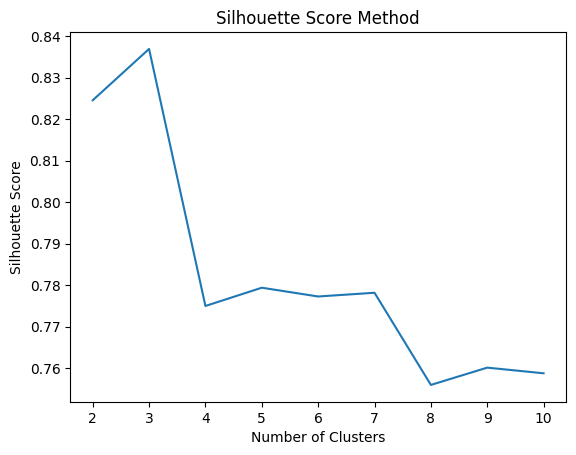

In [25]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Prepare the data for training
X = df[['LONGITUDE', 'LATITUDE']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Calculate the silhouette scores for different numbers of clusters
silhouette_scores = []
max_clusters = 10  # Maximum number of clusters to consider
for n_clusters in range(2, max_clusters + 1):
    kmeans_model = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_model.fit(X_scaled)
    labels = kmeans_model.labels_
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# Plot the silhouette scores against the number of clusters
plt.plot(range(2, max_clusters + 1), silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.show()


In [26]:
# Select the best number of clusters
best_n_clusters = np.argmax(silhouette_scores) + 2
print("Best Number of Clusters:", best_n_clusters)

Best Number of Clusters: 3


In [27]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score

X = df[['LATITUDE', 'LONGITUDE']]

scaler = StandardScaler()
X = scaler.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans_model = KMeans(n_clusters=best_n_clusters, random_state=42)
# Add to the dataframe the cluster of each point
# X['CLUSTER'] = kmeans_model.fit_predict(X_scaled)
kmeans_model.fit(X_scaled)

# Predict the clusters
y_pred = kmeans_model.labels_

# Evaluate the clustering performance using silhouette score
silhouette = silhouette_score(X_scaled, y_pred)
print("Silhouette Score:", silhouette)

Silhouette Score: 0.8368997003727747


In [28]:
# new_data is the last 0.01% of the dataframe only with the columns 'LATITUDE' and 'LONGITUDE'
# new_data = df.tail(int(len(df)*0.0001))[['LATITUDE', 'LONGITUDE']]

In [29]:
# print(new_data.head())

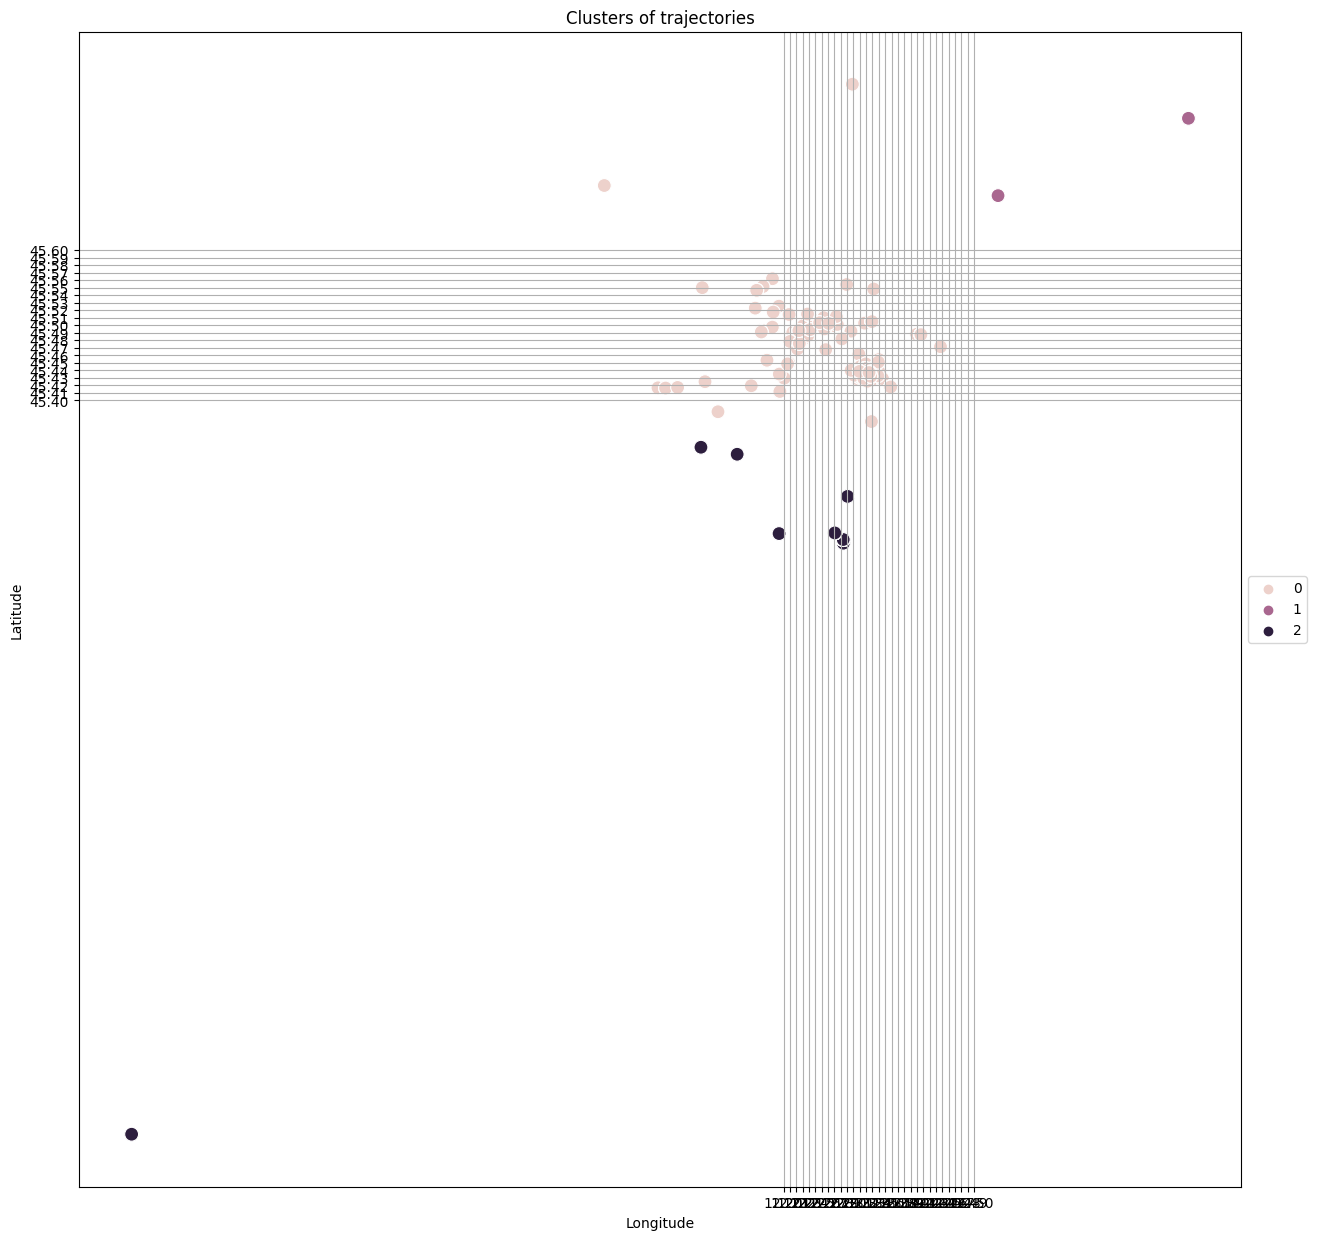

In [30]:
# new_data_scaled = scaler.transform(new_data)
# new_data_clusters = kmeans_model.predict(new_data_scaled)
# new_data_scaled = np.c_[new_data_scaled, new_data_clusters]

# # Access unique cluster labels in the new data
# new_data_clusters_unique = np.unique(new_data_clusters)

# # Add to the dataframe the cluster of each point
# # new_data_scaled['CLUSTER'] = kmeans_model.fit_predict(X_scaled)

# # Add CLUSTER column to the new_data dataframe
# # new_data['CLUSTER'] = new_data_clusters
# # Add CLUSTER column to the X dataframe

# print("New Data Clusters:", new_data_scaled)

# # Define hue CLUSTER
# hue = new_data_clusters

# Plot the clusters both of the new data and of the old data
fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(x='LONGITUDE', y='LATITUDE', data=df, hue=kmeans_model.labels_, s=100, ax=ax)
# sns.scatterplot(x='LONGITUDE', y='LATITUDE', data=new_data, hue=hue, s=100, ax=ax)
# Set the title
ax.set_title('Clusters of trajectories')
# Set the legend
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
# Set the x and y labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
# Set the x and y ticks
ax.set_xticks(np.arange(12.2, 12.5, 0.01))
ax.set_yticks(np.arange(45.4, 45.6, 0.01))
# Set the grid
ax.grid(True)

plt.show()

In [31]:
# Print information about the clusters
for cluster in np.unique(y_pred):   
    print("Cluster:", cluster)
    print("Number of Users:", len(df[y_pred == cluster]['SERIALE'].unique()))

Cluster: 0
Number of Users: 3608
Cluster: 1
Number of Users: 19
Cluster: 2
Number of Users: 92


In [32]:
# Represent the clusters in the map obtained with KMeans
# Create a map
m = folium.Map(location=[45.437190, 12.334590], zoom_start=13)

# Create a marker cluster
marker_cluster = MarkerCluster().add_to(m)

colors = ['red', 'blue', 'green', 'purple', 'orange', 'gray', 'darkred', 'lightred', 'beige', 'darkblue']

# Define a list of stops already inserted
# Each element of the list is a tuple (latitude, longitude)
stops_inserted = []

# Represent the clusters in the map
for cluster in np.unique(y_pred):
    # Get the rows of the dataframe for the specified cluster
    df_cluster = df[y_pred == cluster]   
    cluster_coordinates = df_cluster[['LATITUDE', 'LONGITUDE']].values
    # Calculate the mean of the coordinates of the cluster
    cluster_coordinates_mean = np.mean(cluster_coordinates, axis=0)
    # Insert the coordinates of the cluster in the map
    # folium.CircleMarker(location=[cluster_coordinates_mean[0], cluster_coordinates_mean[1]], popup='Cluster {}'.format(cluster), color=colors[cluster%len(colors)], fill=True, fill_color=colors[cluster%len(colors)], fill_opacity=0.7).add_to(marker_cluster)
    # Insert the coordinates of the cluster in the map with a proportional radius (set a maximum radius)
    radius = round(0.0002 * len(df_cluster))
    # Be sure that the radius is greater than 1
    radius = max(radius, 1)
    print('Cluster {} has {} users and radius {}'.format(cluster, len(df_cluster), radius))
    folium.CircleMarker(location=[cluster_coordinates_mean[0], cluster_coordinates_mean[1]], radius=min(radius, 20), popup='Cluster {}'.format(cluster), color=colors[cluster%len(colors)], fill=True, fill_color=colors[cluster%len(colors)], fill_opacity=0.7).add_to(marker_cluster)
    # Highlight the trajectory of the user
    # folium.PolyLine(locations=df_cluster[['LATITUDE', 'LONGITUDE']].values.tolist(), weight=2, color=colors[cluster%len(colors)]).add_to(m)

# Display the map
m


Cluster 0 has 3761 users and radius 1
Cluster 1 has 19 users and radius 1
Cluster 2 has 95 users and radius 1


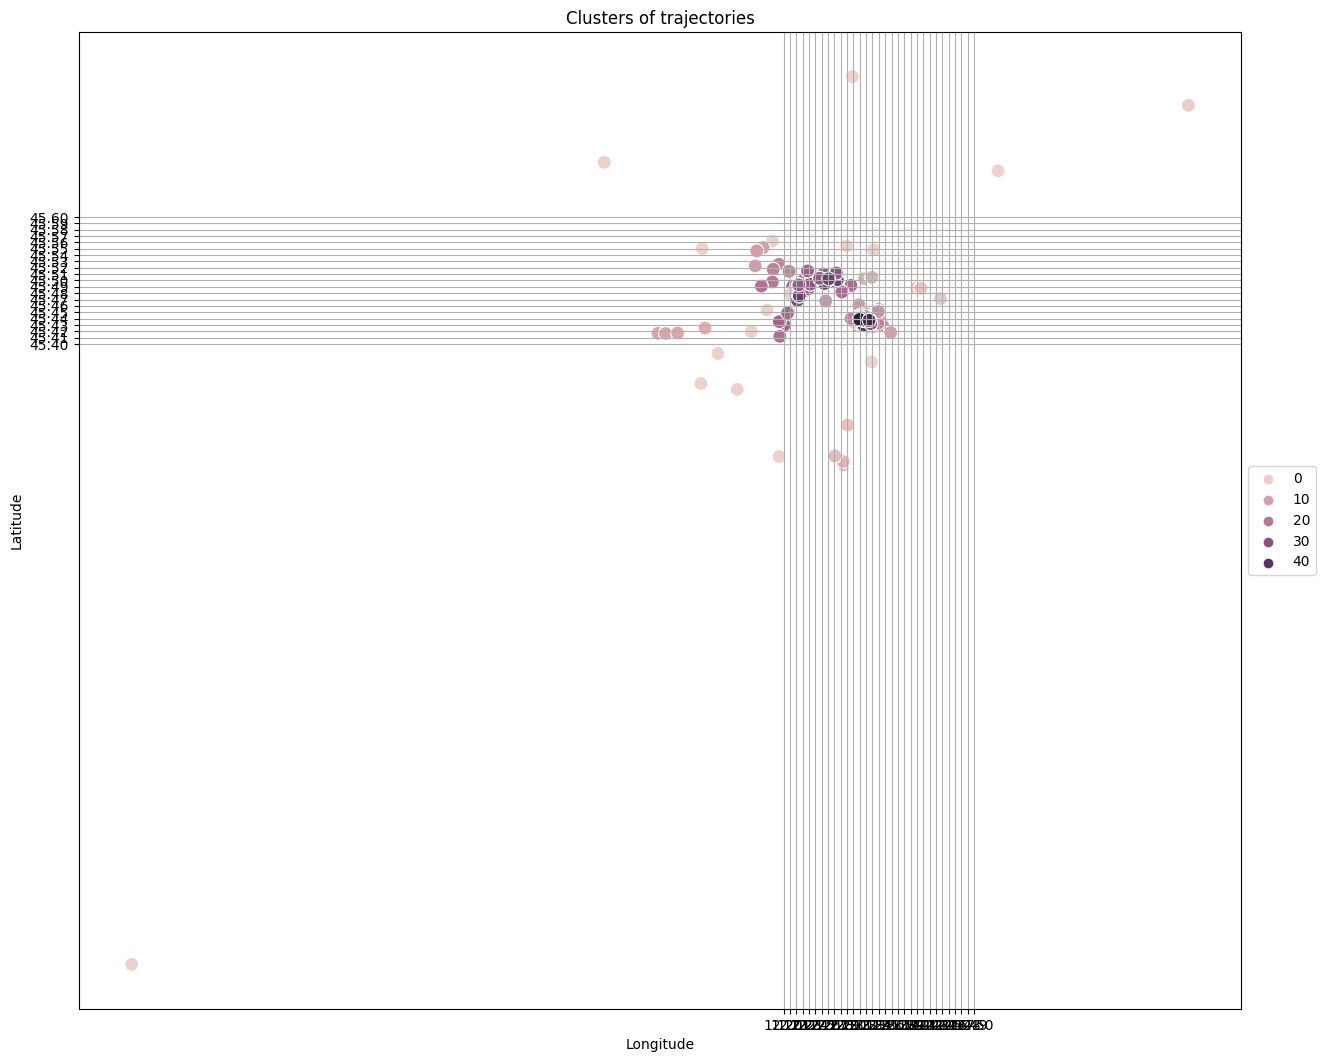

In [42]:
# Apply HDBSCAN to the data
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean', core_dist_n_jobs=5)
clusterer.fit(np.radians(df[['LATITUDE', 'LONGITUDE']]))
df['CLUSTER'] = clusterer.labels_

# Plot the clusters
fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(x='LONGITUDE', y='LATITUDE', data=df, hue='CLUSTER', s=100, ax=ax)
# Set the title
ax.set_title('Clusters of trajectories')
# Set the legend
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
# Set the x and y labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Set the x and y ticks
ax.set_xticks(np.arange(12.2, 12.5, 0.01))
ax.set_yticks(np.arange(45.4, 45.6, 0.01))
# Set the grid
ax.grid(True)
# Set the aspect ratio
ax.set_aspect('equal', 'box')

plt.show()

In [43]:
# Represent the clusters in the map obtained with HDBSCAN
# Create a map
m = folium.Map(location=[45.437190, 12.334590], zoom_start=13)

# Create a marker cluster
marker_cluster = MarkerCluster().add_to(m)

# Define a list of stops already inserted
# Each element of the list is a tuple (latitude, longitude)
stops_inserted = []

# Represent the clusters in the map
for cluster in np.unique(df['CLUSTER']):
    # Get the rows of the dataframe for the specified cluster
    df_cluster = df[df['CLUSTER'] == cluster]   
    cluster_coordinates = df_cluster[['LATITUDE', 'LONGITUDE']].values
    # Calculate the mean of the coordinates of the cluster
    cluster_coordinates_mean = np.mean(cluster_coordinates, axis=0)
    # Insert the coordinates of the cluster in the map
    # folium.CircleMarker(location=[cluster_coordinates_mean[0], cluster_coordinates_mean[1]], popup='Cluster {}'.format(cluster), color=colors[cluster%len(colors)], fill=True, fill_color=colors[cluster%len(colors)], fill_opacity=0.7).add_to(marker_cluster)
    # Insert the coordinates of the cluster in the map with a proportional radius (set a maximum radius)
    radius = round(0.0002 * len(df_cluster))
    # Be sure that the radius is greater than 1
    radius = max(radius, 1)
    print('Cluster {} has {} users and radius {}'.format(cluster, len(df_cluster), radius))
    folium.CircleMarker(location=[cluster_coordinates_mean[0], cluster_coordinates_mean[1]], radius=min(radius, 20), popup='Cluster {}'.format(cluster), color=colors[cluster%len(colors)], fill=True, fill_color=colors[cluster%len(colors)], fill_opacity=0.7).add_to(marker_cluster)
    # Highlight the trajectory of the user
    # folium.PolyLine(locations=df_cluster[['LATITUDE', 'LONGITUDE']].values.tolist(), weight=2, color=colors[cluster%len(colors)]).add_to(m)

# Display the map
m

Cluster -1 has 46 users and radius 1
Cluster 0 has 18 users and radius 1
Cluster 1 has 7 users and radius 1
Cluster 2 has 120 users and radius 1
Cluster 3 has 5 users and radius 1
Cluster 4 has 67 users and radius 1
Cluster 5 has 13 users and radius 1
Cluster 6 has 22 users and radius 1
Cluster 7 has 11 users and radius 1
Cluster 8 has 5 users and radius 1
Cluster 9 has 9 users and radius 1
Cluster 10 has 449 users and radius 1
Cluster 11 has 10 users and radius 1
Cluster 12 has 6 users and radius 1
Cluster 13 has 13 users and radius 1
Cluster 14 has 29 users and radius 1
Cluster 15 has 26 users and radius 1
Cluster 16 has 234 users and radius 1
Cluster 17 has 12 users and radius 1
Cluster 18 has 24 users and radius 1
Cluster 19 has 29 users and radius 1
Cluster 20 has 6 users and radius 1
Cluster 21 has 12 users and radius 1
Cluster 22 has 8 users and radius 1
Cluster 23 has 9 users and radius 1
Cluster 24 has 7 users and radius 1
Cluster 25 has 8 users and radius 1
Cluster 26 has 16 

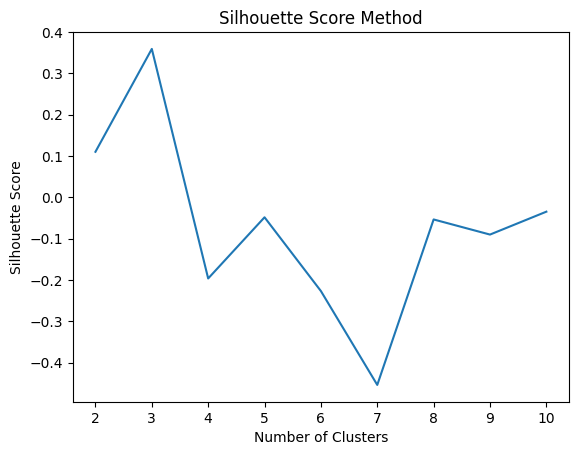

Best Number of Clusters: 3


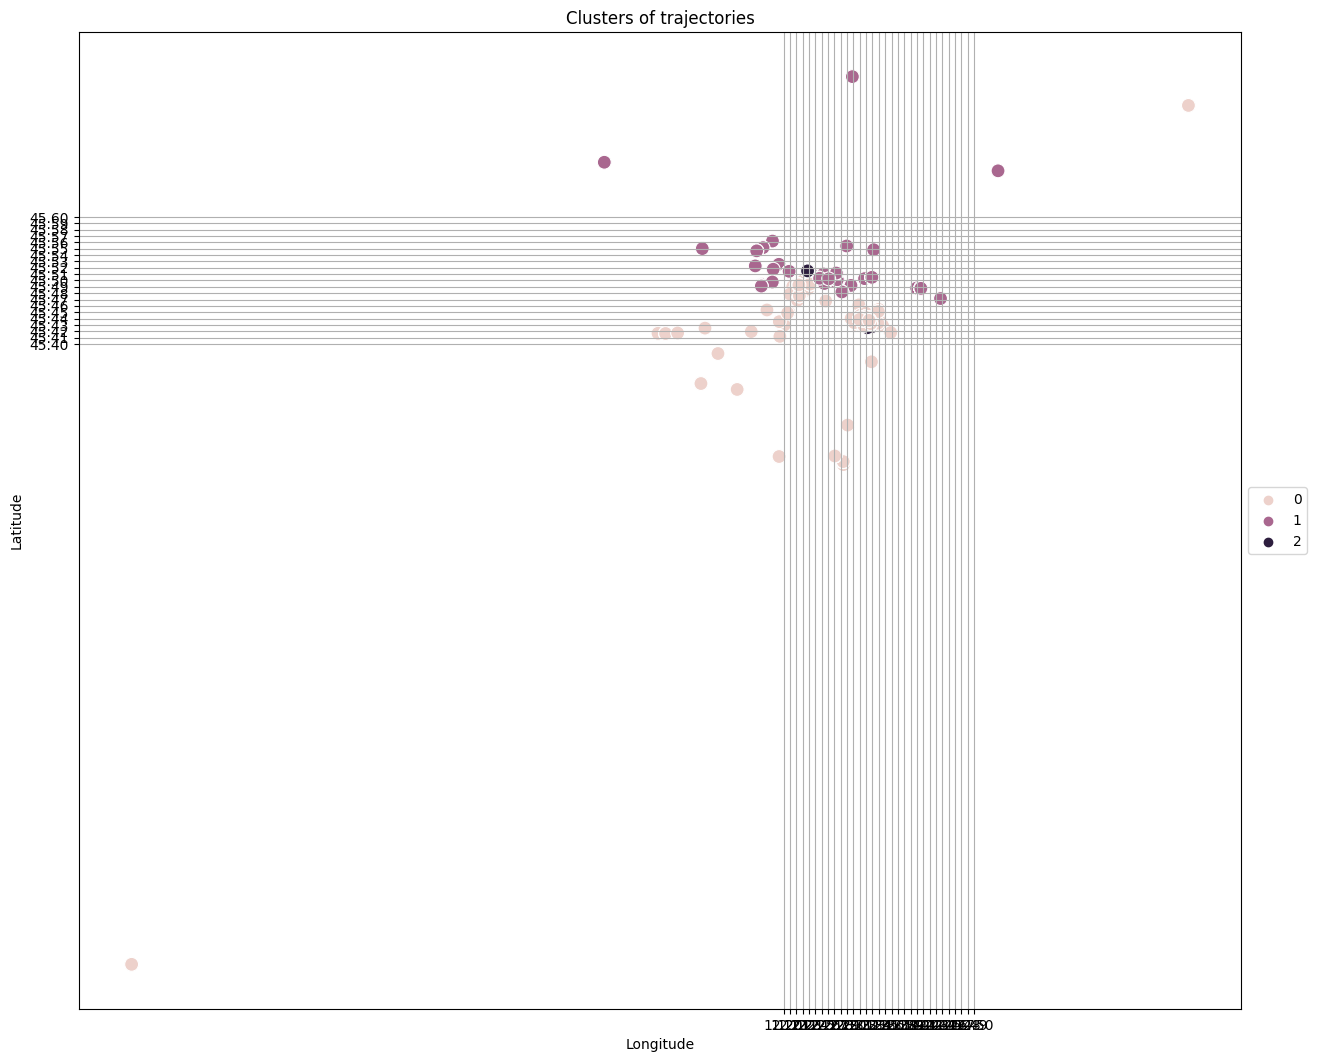

In [44]:
# Use spectral clustering to cluster the trajectories
from sklearn.cluster import SpectralClustering

# Prepare the data for training
X = df[['LONGITUDE', 'LATITUDE']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Calculate the silhouette scores for different numbers of clusters
silhouette_scores = []
max_clusters = 10  # Maximum number of clusters to consider
for n_clusters in range(2, max_clusters + 1):
    spectral_model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
    spectral_model.fit(X_scaled)
    labels = spectral_model.labels_
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# Plot the silhouette scores against the number of clusters
plt.plot(range(2, max_clusters + 1), silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.show()

# Select the best number of clusters
best_n_clusters = np.argmax(silhouette_scores) + 2
print("Best Number of Clusters:", best_n_clusters)

# Apply spectral clustering to the data
from sklearn.cluster import SpectralClustering

# Spectral clustering
spectral_model = SpectralClustering(n_clusters=best_n_clusters, affinity='nearest_neighbors', random_state=42)
df['CLUSTER'] = spectral_model.fit_predict(X_scaled)

# Plot the clusters
fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(x='LONGITUDE', y='LATITUDE', data=df, hue='CLUSTER', s=100, ax=ax)
# Set the title
ax.set_title('Clusters of trajectories')
# Set the legend
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
# Set the x and y labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Set the x and y ticks
ax.set_xticks(np.arange(12.2, 12.5, 0.01))
ax.set_yticks(np.arange(45.4, 45.6, 0.01))
# Set the grid
ax.grid(True)
# Set the aspect ratio
ax.set_aspect('equal', 'box')

plt.show()


In [45]:
# represent the clusters in the map obtained with spectral clustering
# Create a map
m = folium.Map(location=[45.437190, 12.334590], zoom_start=13)

# Create a marker cluster
marker_cluster = MarkerCluster().add_to(m)

# Define a list of stops already inserted
# Each element of the list is a tuple (latitude, longitude)

# Represent the clusters in the map
for cluster in np.unique(df['CLUSTER']):
    # Get the rows of the dataframe for the specified cluster
    df_cluster = df[df['CLUSTER'] == cluster]   
    cluster_coordinates = df_cluster[['LATITUDE', 'LONGITUDE']].values
    # Calculate the mean of the coordinates of the cluster
    cluster_coordinates_mean = np.mean(cluster_coordinates, axis=0)
    # Insert the coordinates of the cluster in the map
    # folium.CircleMarker(location=[cluster_coordinates_mean[0], cluster_coordinates_mean[1]], popup='Cluster {}'.format(cluster), color=colors[cluster%len(colors)], fill=True, fill_color=colors[cluster%len(colors)], fill_opacity=0.7).add_to(marker_cluster)
    # Insert the coordinates of the cluster in the map with a proportional radius (set a maximum radius)
    radius = round(0.0002 * len(df_cluster))
    # Be sure that the radius is greater than 1
    radius = max(radius, 1)
    print('Cluster {} has {} users and radius {}'.format(cluster, len(df_cluster), radius))
    folium.CircleMarker(location=[cluster_coordinates_mean[0], cluster_coordinates_mean[1]], radius=min(radius, 20), popup='Cluster {}'.format(cluster), color=colors[cluster%len(colors)], fill=True, fill_color=colors[cluster%len(colors)], fill_opacity=0.7).add_to(marker_cluster)
    # Highlight the trajectory of the user
    # folium.PolyLine(locations=df_cluster[['LATITUDE', 'LONGITUDE']].values.tolist(), weight=2, color=colors[cluster%len(colors)]).add_to(m)

# Display the map
m


Cluster 0 has 3560 users and radius 1
Cluster 1 has 279 users and radius 1
Cluster 2 has 36 users and radius 1
